In [108]:
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [109]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 5
    FOLDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    
    
class paths:
    OUTPUT_DIR = "." # "/kaggle/working/"
    TRAIN_CSV = "/data/hms/train.csv" 
    TRAIN_EEGS = "/data/hms/train_eegs/"

In [110]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

In [111]:
train_df = pd.read_csv(paths.TRAIN_CSV)
label_cols = train_df.columns[-6:]
print(f"Train cataframe shape is: {train_df.shape}")
print(f"Labels: {list(label_cols)}")
train_df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [113]:
eeg_df = pd.read_parquet(paths.TRAIN_EEGS + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


0it [00:00, ?it/s]

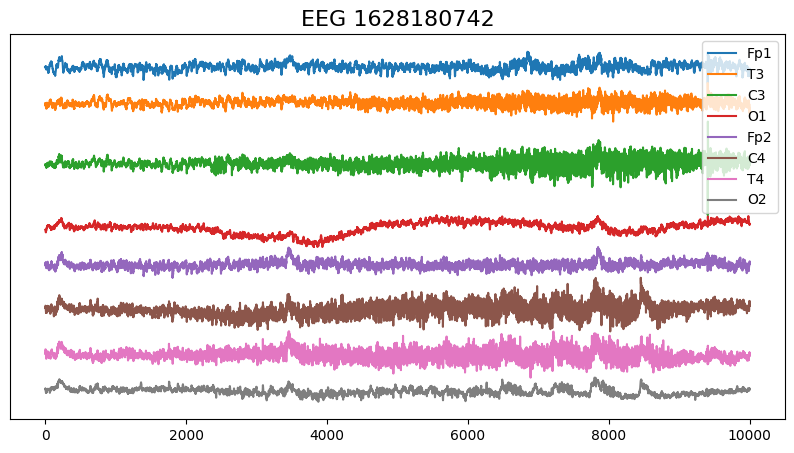

1it [00:00,  2.47it/s]


Reading 17089 eeg NumPys from disk.


In [114]:
CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TRAIN_EEGS + "*.parquet")
eeg_ids = train_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TRAIN_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path, display=i<visualize)              
    all_eegs[eeg_id] = data
    
    if i == visualize:
        if CREATE_EEGS:
            print(f'Processing {train_df.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(eeg_ids)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs', all_eegs)
else:
    all_eegs = np.load('/data/hms/eegs.npy',allow_pickle=True).item()

In [115]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]

train_df = df.groupby('eeg_id')[['patient_id']].agg('first')
aux = df.groupby('eeg_id')[label_cols].agg('sum') 

for label in label_cols:
    train_df[label] = aux[label].values
    
y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
train_df = train_df.loc[train_df.eeg_id.isin(eeg_ids)]
print(f"Train dataframe with unique eeg_id has shape: {train_df.shape}")
train_df.head()

Train dataframe with unique eeg_id has shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [116]:
from sklearn.model_selection import KFold, GroupKFold


gkf = GroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size()), sep()
display(train_df.head())

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.0
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,1.0
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4.0
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2.0
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,0.0


In [117]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


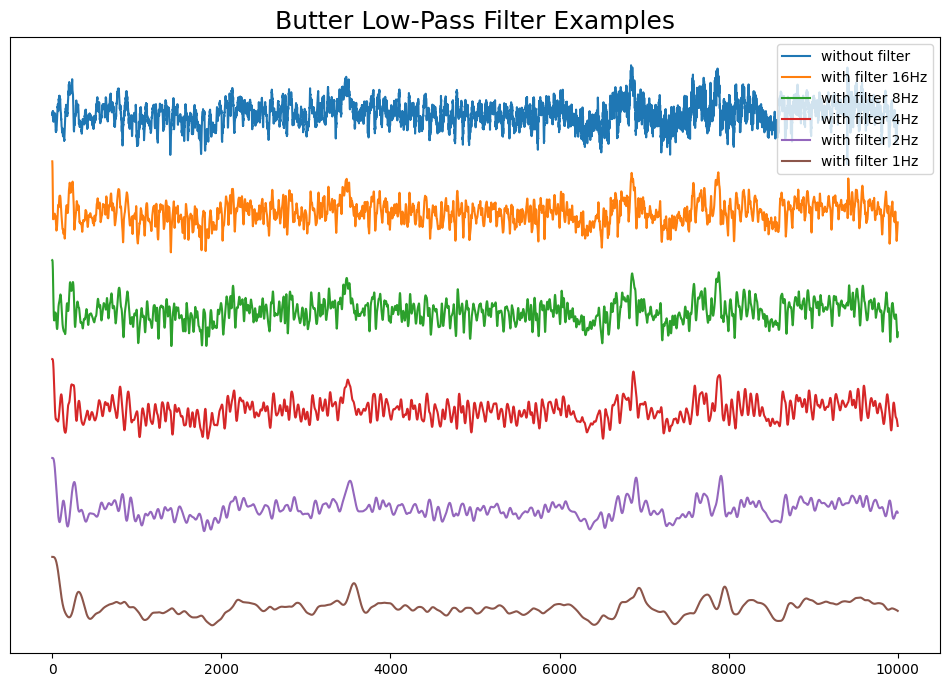

In [118]:
frequencies = [1,2,4,8,16][::-1] # frequencies in Hz
x = [all_eegs[eeg_ids[0]][:,0]] # select one EEG feature

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

In [119]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y = self.__data_generation(index)
        X = X[::self.downsample,:]
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X, y

In [120]:
train_dataset = CustomDataset(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["X"], output["y"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([2000, 8])
y shape: torch.Size([6])


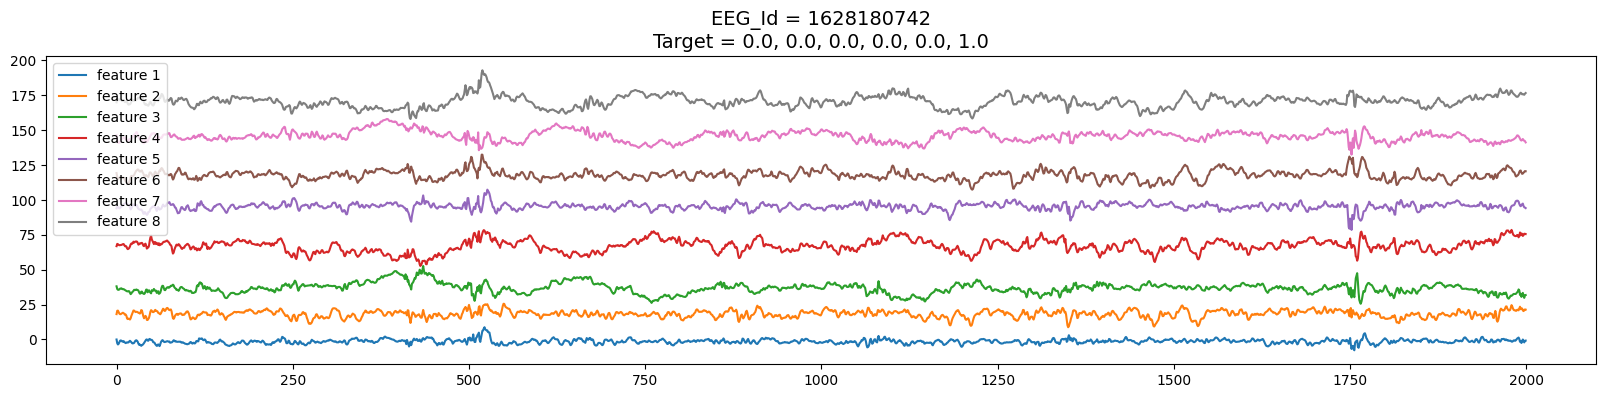

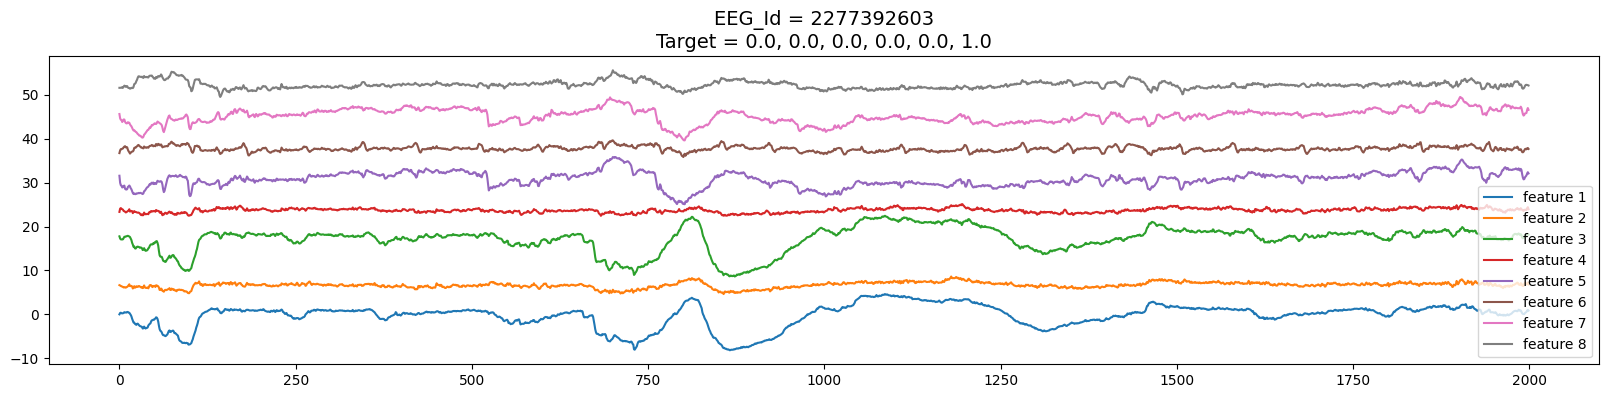

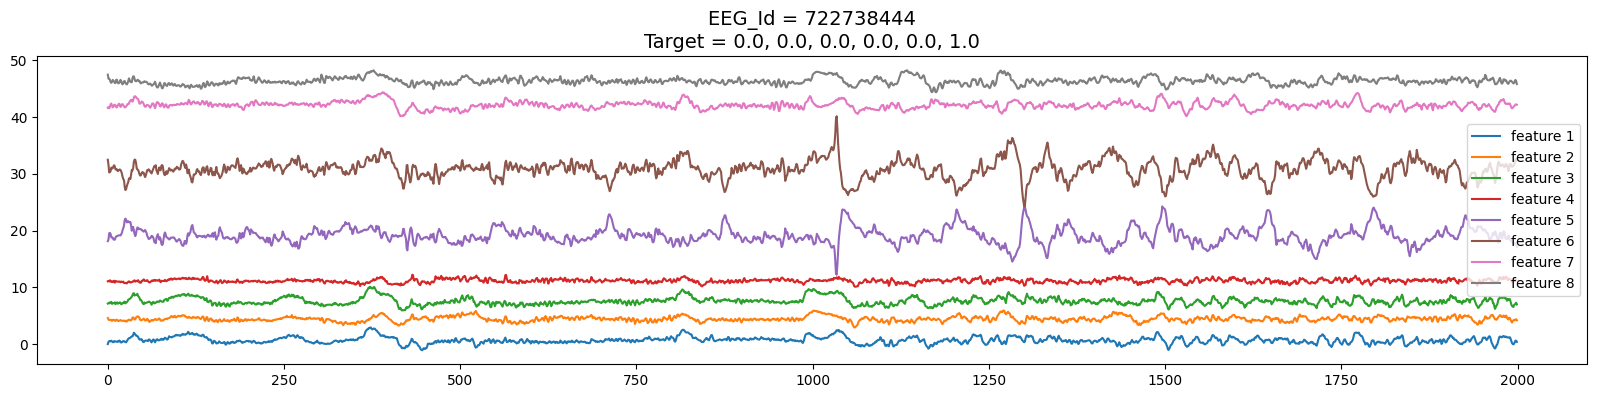

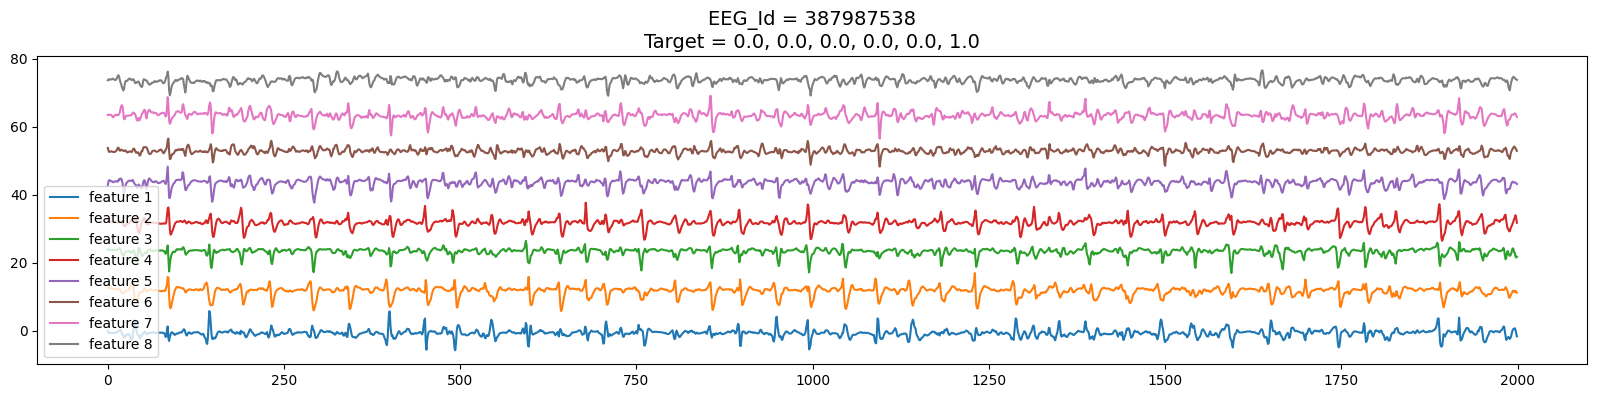

In [121]:
if config.VISUALIZE:
    for batch in train_loader:
        X = batch.pop("X")
        y = batch.pop("y")
        for item in range(4):
            plt.figure(figsize=(20,4))
            offset = 0
            for col in range(X.shape[-1]):
                if col != 0:
                    offset -= X[item,:,col].min()
                plt.plot(range(2_000), X[item,:,col]+offset,label=f'feature {col+1}')
                offset += X[item,:,col].max()
            tt = f'{y[col][0]:0.1f}'
            for t in y[col][1:]:
                tt += f', {t:0.1f}'
            plt.title(f'EEG_Id = {eeg_ids[item]}\nTarget = {tt}',size=14)
            plt.legend()
            plt.show()
        break

In [122]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output = self.model(x)
        return output


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forwward pass.
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=1)
        y = self.head(y)
        
        return y

model = CustomModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 98086


Maximum LR: 0.001 | Minimum LR: 4.0000000000000003e-07


/home/ubuntu/.cache/pypoetry/virtualenvs/hmc-snuh-QMWTtYeW-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


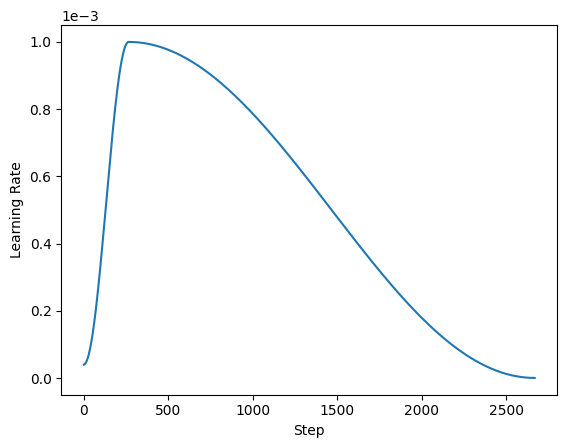

In [123]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = config.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = CustomModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

In [124]:
import torch.nn.functional as F

# === Reduction = "mean" ===
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(torch.randn(6, 2, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(6, 2), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

print("\n", "="*100, "\n")

# === Reduction = "batchmean" ===
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(torch.randn(2, 6, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(2, 6), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

Predictions: tensor([[-1.9961, -0.1460],
        [-0.6342, -0.7558],
        [-0.1321, -2.0893],
        [-1.0250, -0.4444],
        [-0.0433, -3.1617],
        [-0.5851, -0.8143]], grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.6694, 0.3306],
        [0.5824, 0.4176],
        [0.4294, 0.5706],
        [0.4837, 0.5163],
        [0.5527, 0.4473],
        [0.6195, 0.3805]])
Output: 0.17602171003818512


Predictions: tensor([[-3.2207, -3.4320, -0.7522, -2.0491, -2.5421, -1.3909],
        [-2.4079, -0.5832, -2.0969, -2.5690, -2.4326, -2.7393]],
       grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.1297, 0.2025, 0.2256, 0.1073, 0.1049, 0.2300],
        [0.1990, 0.1291, 0.1577, 0.2164, 0.1257, 0.1722]])
Output: 0.3986283838748932


/home/ubuntu/.cache/pypoetry/virtualenvs/hmc-snuh-QMWTtYeW-py3.10/lib/python3.10/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [125]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            X = batch.pop("X").to(device) # send inputs to `device`
            y = batch.pop("y").to(device) # send labels to `device`
            batch_size = y.size(0)
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_last_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, device):
    model.eval() 
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            X = batch.pop("X").to(device) 
            y = batch.pop("y").to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              remain=timeSince(start, float(step+1)/len(valid_loader)),
                              loss=losses))
                
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

In [126]:
def train_loop(df, fold):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, config, mode="train")
    valid_dataset = CustomDataset(valid_folds, config, mode="train")
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                         f"./wavenet_fold_{fold}_best.pth")

    predictions = torch.load(f"./wavenet_fold_{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [127]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv('./oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

In [139]:
class config:
    BATCH_SIZE_TEST = 32
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False
    
    
class paths:
    OUTPUT_DIR = "./"
    TEST_CSV = "/data/hms/test.csv"
    TEST_EEGS= "/data/hms/test_eegs/"
    
model_weights = [x for x in glob("./*.pth")]
model_weights

['./wavenet_fold_4_best.pth',
 './wavenet_fold_1_best.pth',
 './wavenet_fold_0_best.pth',
 './wavenet_fold_2_best.pth',
 './wavenet_fold_3_best.pth']

In [140]:
model_weights

['./wavenet_fold_4_best.pth',
 './wavenet_fold_1_best.pth',
 './wavenet_fold_0_best.pth',
 './wavenet_fold_2_best.pth',
 './wavenet_fold_3_best.pth']

In [141]:
def eeg_from_parquet(parquet_path: str) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
   
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

In [142]:
test_df = pd.read_csv(paths.TEST_CSV)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [143]:
eeg_parquet_paths = glob(paths.TEST_EEGS + "*.parquet")
eeg_df = pd.read_parquet(eeg_parquet_paths[0])
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [144]:
%%time

CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TEST_EEGS + "*.parquet")
eeg_ids = test_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TEST_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)              
    all_eegs[eeg_id] = data

1it [00:00, 125.08it/s]

CPU times: user 16.1 ms, sys: 35 µs, total: 16.2 ms
Wall time: 13.6 ms


In [145]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

In [146]:
import albumentations as A

In [147]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config,
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TEST
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X = self.__data_generation(index)
        X = X[::self.downsample, :]
        output = {
            "X": torch.tensor(X, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
            
        return X

In [148]:
test_dataset = CustomDataset(test_df, config)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE_TEST,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)
output = test_dataset[0]
X = output["X"]
print(f"X shape: {X.shape}")

X shape: torch.Size([2000, 8])


In [153]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output = self.model(x)
        return output


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forwward pass.
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=1)
        y = self.head(y)
        
        return y

model = CustomModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 98086


In [154]:
def inference_function(test_loader, model, device):
    model.eval() # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, batch in enumerate(tqdm_test_loader):
            X = batch.pop("X").to(device) # send inputs to `device`
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X) # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) # save predictions
                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    return prediction_dict

In [155]:
predictions = []

for model_weight in model_weights:
    test_dataset = CustomDataset(test_df, config)
    train_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE_TEST,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        drop_last=False
    )
    model = CustomModel()
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

Inference: 100%|██████████| 1/1 [00:00<00:00, 20.39test_batch/s]


Inference: 100%|██████████| 1/1 [00:00<00:00, 25.58test_batch/s]


In [156]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
sub[TARGETS] = predictions
sub.to_csv('submission.csv',index=False)
print(f'Submission shape: {sub.shape}')
sub.head()

Submission shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.025522,0.02319,0.001656,0.085841,0.191128,0.672662
